In [2]:
# load modules
import pickle, pdb, os, random, yaml, random, math, torch, math
from collections import OrderedDict
import numpy as np
import torch.nn as nn
from data_loader import get_loader, pathSpecDataset
from torch.utils.data import DataLoader
from vte_model import Vt_Embedder
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
import pandas as pd
import seaborn as sns

In [3]:

results_dir = '/homes/bdoc3/phonDet/results'
spmel_path = '/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized'
model_name = 'newStandardAutovcSpmelParamsUnnormLatent64Out256'
model_path = os.path.join(results_dir, model_name)
config = pickle.load(open(model_path +'/config_params.pkl','rb'))
config.spmel_dir = config.data_dir

with open(spmel_path +'/spmel_params.yaml') as File:
    spmel_params = yaml.load(File, Loader=yaml.FullLoader)
    
emb_ckpt = model_path +'/best_epoch_checkpoint.pth.tar'

device = torch.device(f'cuda:{config.which_cuda}' if torch.cuda.is_available() else 'cpu')

config

Namespace(batch_size=128, chunk_num=6, chunk_seconds=0.5, ckpt_freq=100, config_file='', cuda=True, data_dir='/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized', dropout=0.0, epochs=100, file_name='newStandardAutovcSpmelParamsUnnormLatent64Out256', is_blstm=True, iteration=1, load_ckpt='', lr=0.0001, lstm_num=2, model='choi_k2c2', n_mels=96, no_cuda=False, reg=0, seed=1, short=False, spmel_dir='/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized', test_list='m2_ m10_ m3_ f2_ f4_', use_attention=False, which_cuda=0)

In [4]:
# run model
vte =  Vt_Embedder(config, spmel_params)
for param in vte.parameters():
    param.requires_grad = False
vte_optimizer = torch.optim.Adam(vte.parameters(), 0.0001)
vte_checkpoint = torch.load(emb_ckpt)
new_state_dict = OrderedDict()
for i, (key, val) in enumerate(vte_checkpoint['model_state_dict'].items()):
#     if key.startswith('class_layer'):
#         continue
    new_state_dict[key] = val
vte.load_state_dict(new_state_dict)

for state in vte_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda(which_cuda)

vte.to(device)
vte.eval()

# prep dataset
vocalSet = pathSpecDataset(config, spmel_params)
vocalSet_loader = DataLoader(vocalSet, batch_size=config.batch_size, shuffle=True, drop_last=False)

In [13]:
# infer embeddings
example_data = []
for i in range(5):
    try:
        x_real, style_idx, singer_idx = next(data_iter)
    except:
        data_iter = iter(vocalSet_loader)
        x_real, style_idx, singer_idx = next(data_iter)
    x_real = x_real.to(device)

    x_real_chunked = x_real.view(x_real.shape[0]*config.chunk_num, x_real.shape[1]//config.chunk_num, -1)
    pred_style_idx, all_tensors = vte(x_real_chunked)
    _, predicted = torch.max(pred_style_idx.data, 1)
    for j in range(len(x_real)):
        # last entry in example_data is a list of all embeddings for that example
        example_data.append((x_real[j], style_idx[j], singer_idx[j], predicted[j], [embs[j] for embs in all_tensors]))

In [19]:
style_names = ['belt','lip_trill','straight','vocal_fry','vibrato','breathy']
num_class = len(style_names)
embs, preds, g_truths = [], [], []
for i in range(len(example_data)):
    embs.append(example_data[i][-1][-1].detach().cpu().numpy())
    g_truths.append(example_data[i][1].detach().cpu().numpy())
    preds.append(example_data[i][3].detach().cpu().numpy())

list_of_embs = [[] for i in range(num_class)]
wrong = correct = 0
for i in range(len(example_data)):
    if preds[i] == g_truths[i]:
        correct += 1
        list_of_embs[preds[i]].append(embs[i])
    else: wrong += 1
print(correct, wrong)

595 45


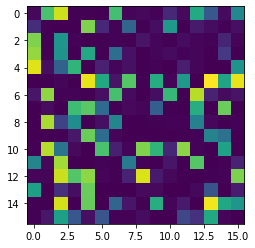

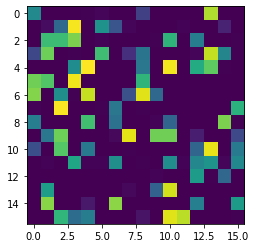

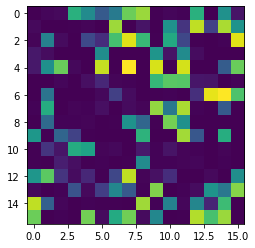

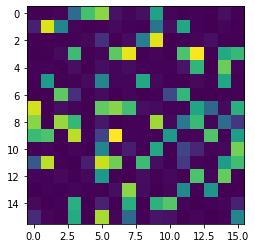

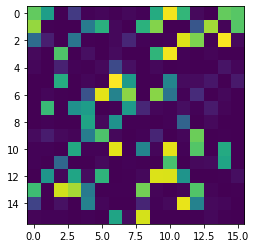

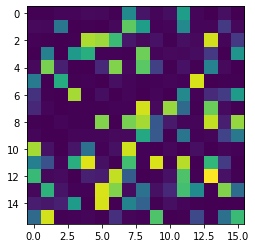

In [35]:
# average, save, print embs

def tensor_to_matrix(array):
    sqr = int(math.sqrt(array.shape[0]))
    embs_mat = array.reshape((sqr,sqr))
    return embs_mat

avg_emb_arr = None
for i in range(num_class):
    avg_emb = np.mean(np.asarray(list_of_embs[i]), axis=0)
    try:
        avg_emb_arr = np.vstack((avg_emb_arr, avg_emb))
    except:
        avg_emb_arr = avg_emb

# save avg_embs for future use
np.save(model_path +'/averaged_embs', avg_emb_arr)

for avg_emb in avg_emb_arr:
    sqr_avg_emb = tensor_to_matrix(avg_emb)
    plt.figure()
    plt.imshow(sqr_avg_emb)

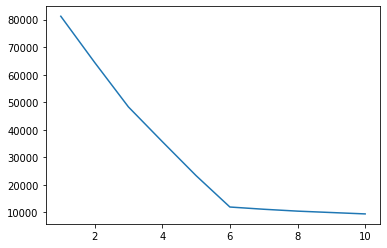

In [20]:
from sklearn.cluster import KMeans

# set up k_means clustering
k_range = range(1,11)
embs_array = np.asarray(embs)

sum_squared_error = []
for k_dim in k_range:    
    km = KMeans(n_clusters=k_dim)
    km.fit_predict(embs_array)
#    print(km.cluster_centers_.shape, km.cluster_centers_) 
    sum_squared_error.append(km.inertia_)
plt.plot(k_range, sum_squared_error)

In [21]:
hc = AgglomerativeClustering(n_clusters=6, affinity = 'euclidean', linkage='ward')
hc_clustering = hc.fit_predict(embs)
hc_sil_score = silhouette_score(embs, hc_clustering, metric='euclidean')
hc_sil_score
# kmeans_cluster_accuracy = adjusted_rand_score(kmeans_cluster_list, rearranged_class_list)

0.6045818

In [36]:
style_idx

tensor([0, 4, 1, 5, 4, 5, 0, 3, 0, 5, 4, 1, 0, 1, 2, 5, 0, 4, 4, 5, 4, 4, 5, 4,
        2, 3, 4, 5, 3, 4, 1, 1, 3, 1, 4, 1, 5, 5, 2, 2, 3, 3, 1, 4, 3, 0, 4, 1,
        4, 0, 1, 5, 4, 4, 1, 4, 3, 1, 0, 4, 0, 3, 0, 2, 1, 5, 2, 0, 1, 5, 3, 4,
        1, 4, 0, 5, 2, 0, 4, 2, 1, 3, 0, 3, 3, 4, 0, 0, 2, 2, 1, 5, 1, 2, 1, 5,
        5, 2, 2, 2, 0, 3, 2, 1, 3, 4, 0, 3, 4, 3, 4, 5, 1, 2, 2, 0, 1, 2, 1, 0,
        4, 0, 4, 2, 1, 4, 0, 3])

In [40]:
qwe = avg_emb_arr[style_idx]
for i in range(len(avg_emb_arr)):
    print(i, avg_emb_arr[i][0])

0 0.053082224
1 1.0168594
2 0.0057163597
3 0.013125768
4 1.7218978
5 0.012515484


In [42]:
for i in qwe:
    print(i[0])

0.053082224
1.7218978
1.0168594
0.012515484
1.7218978
0.012515484
0.053082224
0.013125768
0.053082224
0.012515484
1.7218978
1.0168594
0.053082224
1.0168594
0.0057163597
0.012515484
0.053082224
1.7218978
1.7218978
0.012515484
1.7218978
1.7218978
0.012515484
1.7218978
0.0057163597
0.013125768
1.7218978
0.012515484
0.013125768
1.7218978
1.0168594
1.0168594
0.013125768
1.0168594
1.7218978
1.0168594
0.012515484
0.012515484
0.0057163597
0.0057163597
0.013125768
0.013125768
1.0168594
1.7218978
0.013125768
0.053082224
1.7218978
1.0168594
1.7218978
0.053082224
1.0168594
0.012515484
1.7218978
1.7218978
1.0168594
1.7218978
0.013125768
1.0168594
0.053082224
1.7218978
0.053082224
0.013125768
0.053082224
0.0057163597
1.0168594
0.012515484
0.0057163597
0.053082224
1.0168594
0.012515484
0.013125768
1.7218978
1.0168594
1.7218978
0.053082224
0.012515484
0.0057163597
0.053082224
1.7218978
0.0057163597
1.0168594
0.013125768
0.053082224
0.013125768
0.013125768
1.7218978
0.053082224
0.053082224
0.0057163597